In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
class PPOAgent:
    def __init__(self, n_actions, n_features, reward_decay=0.99,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, learning_rate_decay=0.95,
                 ):
        self.state_size = n_features
        self.action_size = n_actions
        self.gamma = reward_decay   # discount rate
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.entfact = 1e-3 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {} # store the memory for different agents
        self.history['states'] = []
        self.history['actions'] = []
        self.history['discounted_rs'] = []
        self.history['advantages'] = []
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')

        # critic
        with tf.variable_scope('critic'):
            net = tf.layers.dense(self.tfs, 10, tf.nn.relu)
            self.v = tf.layers.dense(net, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.closs = tf.reduce_mean(tf.square(self.tfdc_r - self.v))
            self.ctrain_op = tf.train.AdamOptimizer(self.critic_learning_rate).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        self.pi_probs = tf.nn.softmax(pi)
        self.oldpi_probs = tf.nn.softmax(oldpi)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(tf.multinomial(pi, 1), axis=0)       # choosing action
#             self.sample_op_old = tf.squeeze(tf.multinomial(oldpi, 1), axis=0)
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.int32, [None, 1], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        self.tfa_one_hot = tf.contrib.layers.one_hot_encoding(self.tfa, self.action_size)
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                self.ratio = tf.reduce_sum(self.pi_probs * self.tfa_one_hot) / (tf.reduce_sum(self.oldpi_probs * self.tfa_one_hot)+1e-10)
                surr = self.ratio * self.tfadv
                surr2 = tf.clip_by_value(self.ratio, 1-self.epsilon, 1+self.epsilon) * self.tfadv
                entropy = - tf.reduce_sum(self.pi_probs * tf.log(self.pi_probs + 1e-10))
                self.aloss = - tf.reduce_mean(tf.minimum(surr, surr2)) - self.entfact * entropy

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(self.actor_learning_rate).minimize(self.aloss, var_list=pi_params)

        self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            net = tf.layers.dense(self.tfs, 10, tf.nn.relu, trainable=trainable)
            logits = tf.layers.dense(net, self.action_size, trainable=trainable)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return logits, params
    
    def choose_action(self, state):
        return self.sess.run(self.sample_op, {self.tfs: state})[0]
    
    def remember(self, state, action, reward):
        self.memory += [[state[0], action, reward]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        actions = np.vstack(memory[:,1])
        rewards = memory[:,2]
        discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        value_estimates = self.sess.run(self.v, {self.tfs: states}).flatten()
        value_estimates = np.append(value_estimates, 0)
        delta_t = rewards + self.gamma * value_estimates[1:] - value_estimates[:-1]
        advs = self.discount_rewards(delta_t, self.gamma * self.lam)[:, newaxis] #gae
        last = states.shape[0]
        self.history['states'] += [states[-last:]]
        self.history['actions'] += [actions[-last:]]
        self.history['discounted_rs'] += [discounted_ep_rs[-last:]]
        self.history['advantages'] += [advs[-last:]]
        self.memory = [] # empty the memory
    
    def replay(self):
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        ac = np.vstack(self.history['actions'])
        dc_r = np.vstack(self.history['discounted_rs'])
        ad = np.vstack(self.history['advantages'])
        
        for _ in range(10): # update K epochs
            s, ac, dc_r, ad = shuffle(s, ac, dc_r, ad)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[start:end], self.tfa: ac[start:end], self.tfadv: ad[start:end]})
                self.sess.run(self.ctrain_op, {self.tfs: s[start:end], self.tfdc_r: dc_r[start:end]})
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[-res:], self.tfa: ac[-res:], self.tfadv: ad[-res:]})
                self.sess.run(self.ctrain_op, {self.tfs: s[-res:], self.tfdc_r: dc_r[-res:]})
#         self.actor_learning_rate *= self.learning_rate_decay
#         self.critic_learning_rate *= self.learning_rate_decay
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [3]:
agent = PPOAgent(n_actions=2, n_features=2, actor_learning_rate=1e-4, critic_learning_rate=1e-4)

# The first player (state = [0,1]) wins if their coins match

### If the second player always plays the same side (side 0)

In [4]:
oppo = 0
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
for ep in range(2000):
    action = agent.choose_action(state)
    if action == oppo:
        reward = 1
    else:
        reward = -1
    agent.remember(state, [action], reward)
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]

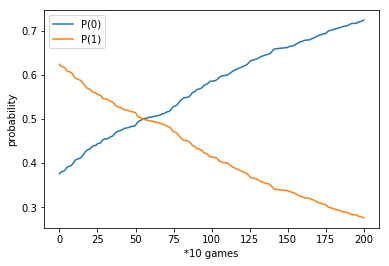

In [5]:
plt.plot(proba0, label="P(0)")
plt.plot(proba1, label="P(1)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### The probability of choosing 0 (P(0)) increases

### Now, if the opponent changes the strategy, always plays side 1

In [6]:
oppo = 1
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
for ep in range(2000):
    action = agent.choose_action(state)
    if action == oppo:
        reward = 1
    else:
        reward = -1
    agent.remember(state, [action], reward)
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]

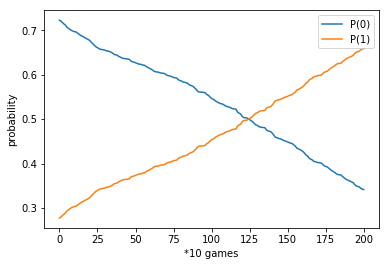

In [14]:
plt.plot(proba0, label="P(0)")
plt.plot(proba1, label="P(1)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### The probability of choosing 1 (P(1)) increases

## Now, play against itself (The second player's state is [1,0])

In [10]:
# agent.critic_learning_rate = agent.actor_learning_rate = 1e-4
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
p1w = 0
eps = 1000

for ep in range(eps):
    action = agent.choose_action(state)
    oppo_action = agent.choose_action(oppo_state)
    if action == oppo_action:
        reward = 2-action
        oppo_reward = -1
        p1w += 1
    else:
        reward = -1
        oppo_reward = 1
    agent.remember(state, [action], reward)
    agent.process_memory()
    agent.remember(oppo_state, [oppo_action], oppo_reward)
    agent.process_memory()
    if (ep+1) % 1 == 0:
        agent.replay()
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
        player1_proba0 += [p[0]]
        player2_proba0 += [p_[0]]
print("Player 1's winning rate :", p1w/eps)

Player 1's winning rate : 0.963


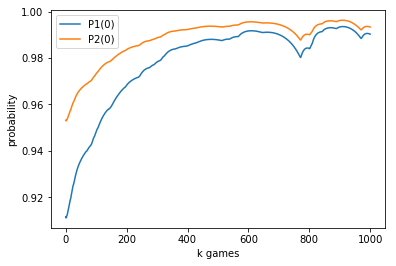

In [11]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('k games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

# The strategies converge to the mixed strategy NE!!

In [10]:
agent.saver.save(agent.sess, "model/matching_pennies_self_play100k.ckpt");

INFO:tensorflow:model/matching_pennies_self_play100k.ckpt is not in all_model_checkpoint_paths. Manually adding it.
